In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp

# Introduction to `qiskit_algorithms` 
Examples of algorithms: 
* `Minimum Eigensolvers` is used to find the smallest eigenvalue of an operator. For example, the minimum eigenvalue of the Hamiltonian operator is the ground state energy.
* `Time Evolvers` as the name suggests, is for the time evolution of a quantum system
* `Amplitude estimators` which I assume is used to estimate the probability for a quantum system to be in a certain state.

## The Variational Quantum Eigensolver (VQE)
Given a Hilbert Space and a Hamiltonian $H$ over it. 
We consider the eigenbasis $\{\ket{\psi_\lambda}\}$ where $\langle\psi_{\lambda_1}\vert\psi_{\lambda_2}\rangle = \delta_{\lambda_1 \lambda_2}$  
The eigenvectors satisfy the eigenvalue equation
$$
H\ket{\psi_\lambda} = E_\lambda \ket{\psi_\lambda}
$$
Suppose one wants to calculate the ground state energy $E_\text{gs}$, the **variational principle** will give an *upper bound* for $E_\text{gs}$ i.e. $E_\text{gs} \leq \bra{\phi}H\ket{\phi}\equiv \langle H \rangle$  
Here $\ket{\phi}$ is an arbitrary **normalized** quantum state, it is evidently true when $\ket{\phi}$ is one of the eigenstates of $H$.  
**Proof**
$$
\begin{gather*}
\ket{\phi} = \sum_\lambda C_\lambda \ket{\phi_\lambda} \\
\sum_i \left(C_i^* \bra{\psi_i} \sum_j C_j \ket{\psi_j}\right)
=\sum_i\sum_j C_i^* C_j \langle{\psi_i}\vert{\psi_j}\rangle
= \sum_i\sum_j C_i^*C_j \delta_{ij} = \sum_\lambda |C_\lambda|^2
=\mathrm{I} \\
\braket{H} = \sum_i \left( C_i^* \bra{\psi_i} H \sum_j C_j \ket{\phi_j}\right)
=\sum_i \sum_j C_i^* C_j E_j \braket{\psi_i\vert\psi_j}
=\sum_i E_i|C_i|^2
\end{gather*}
$$
By definition, the ground state energy $E_\text{gs}$ is the smallest eigenvalue of $H$
, thus $\braket{H} \geq E_\text{gs}\sum_i |C_i|^2 = E_\text{gs}$ is satisfied. 

Based on the variational principle, the VQE tests parametrized trial wave functions, and attempts to find the minimum value using optimization methods.

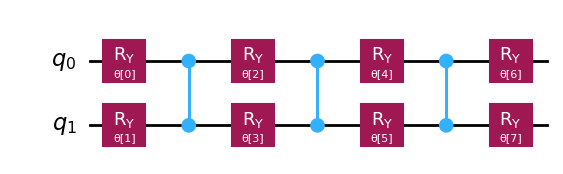

In [5]:
from qiskit import *
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal

num_qubits = 2
ansatz = TwoLocal(num_qubits, "ry", "cz")
optimizer = SLSQP(maxiter=1000) 
ansatz.decompose().draw("mpl", style="iqx")

### `TwoLocal` circuit
> [IBM Quantum Documentation](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal)  
 
The two-local circuit is a parametrized circuit consisting of alternating rotation layers and entanglement layers.
The rotation layers are single qubit gates applied on all qubits.
The entanglement layers uses two-qubit gates to entangle the qubits according to a strategy set using `entanglement`
In the example a rotation about the $y$ axis is performed, and a controlled z-gate is used to entangle the qubit pair.
* Controlled Z gate (`cz`):
$$
\begin{align*}
CZ q_0q_1 &= \mathrm{I}\otimes\ket{0}\bra{0} + \sigma_z \ket{1}\bra{1}\\
&= 
\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}
\otimes
\begin{pmatrix}
1\\0
\end{pmatrix}
\begin{pmatrix}
1 & 0
\end{pmatrix}
+
\begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}
\otimes
\begin{pmatrix}
0\\1
\end{pmatrix}
\begin{pmatrix}
0 & 1
\end{pmatrix}
=
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 &-1
\end{pmatrix}
\end{align*}
$$
As shown in the circuit diagram, the pair of qubits are undergo $y$ rotations followed by `cz` entanglement operation.
The default parameter for `reps` is 3, and `skip_final_rotation_layer` is `false` if unspecified.
This circuit consists of a total of 9 $y$ rotation gates, each angle is a parameter subject to optimization in the `SLSQP` algorithm. 

### Sequential Least Squares Quadratic Programming (SLSQP)
> [[Kraft, 1998]](http://degenerateconic.com/uploads/2018/03/DFVLR_FB_88_28.pdf)  
    A software package for sequential quadratic programming.  
    Tech. Rep. DFVLR-FB 88-28, DLR German Aerospace Center —  
    Institute for Flight Mechanics, Koln, Germany. 

An iterative method for constrained nonlinear optimization.
SQP methods solvea sequence of optimization subproblems,
each of which optimizes a quadratic model of the objecive subject to a linearization of constraints.
* The problem: $\min_x f(x)$
* Subject to constraints
    * $h(x) \geq 0$
    * $g(x) = 0$
* The *Lagrangian* for this problem: $\mathcal{L}(x,\lambda,\sigma) = f(x) - \lambda h(x) - \sigma g(x)$ ($\lambda,\sigma$ are Lagrange multipliers)  
    * The idea of Lagrange multipliers: $\nabla f$ is the direction of which the value of $f$ changes.
$\nabla g$ is the direction of which the value of the constraint changes. Since $g(\mathbf{x})=0$ must be satisfied, this direction is *forbidden*.
The condition $\nabla\mathcal{L} = \nabla(f - \lambda g) = 0$ is satisified at the stationary point. This statement suggests $\nabla_x f - \nabla_x g = 0$ and $\nabla_\lambda \mathcal{L} = 0 \rightarrow g = 0$
Equivalently $\nabla f = \nabla g$, there exists no direction that can both satisify $g$ and change the value of $f$, thus a stationary point.
* Target: To find a stationary point of $f(x)$ by method of Lagrange multipliers $\nabla \mathcal{L}=0$
The algorithm: ($\nabla^2_{xx}$ denotes the Hessian matrix):
$$
\begin{bmatrix}
x_{k+1} \\
\lambda_{k+1} \\
\sigma_{k+1}
\end{bmatrix}
= 
\begin{bmatrix}
x_{k} \\
\lambda_{k} \\
\sigma_{k}
\end{bmatrix}
-
\underbrace{
\begin{bmatrix}
\nabla_{xx}^2 \mathcal{L} & \nabla h & \nabla h \\
\nabla h^T & 0 & 0 \\
\nabla g^T & 0 & 0
\end{bmatrix}^{-1}}_{\nabla^2 \mathcal{L}} \:
\underbrace{
\begin{bmatrix}
\nabla f + \lambda_k \nabla h + \sigma_k \nabla g \\
h \\
g \\
\end{bmatrix}}_{\nabla \mathcal{L}}
$$
The meaning of this equation is essentially $\mathcal{L}_{k+1} - \mathcal{L}_k = -\nabla\mathcal{L}/\nabla^2\mathcal{L}$, which resembles *Newton's method* for optimization.
Since $\nabla^2 \mathcal{L}$ is in general non-invertable, the algorithm solves for a suitable *Newton step*
$d_k = (\nabla^2_{xx}\mathcal{L})^{-1}\nabla\mathcal{L}$, which is the solution to the *quadratic programming subproblem*
$$\begin{align*}
\min_d & f(x_k) + \nabla f(x_k)^T d + \frac12 d^T \nabla^2_{xx}\mathcal{L}(x_k,\lambda_k,\sigma_k)d \\
\text{such that } & h(x_k) + \nabla h(x_k)^T d \geq 0 \\
& g(x_k) + \nabla g(x_k)^T d = 0
\end{align*}
$$
At each iteration $d_k$ is solved, and the value is updated $[x_{k+1},\lambda_{k+1},\sigma_{k+1}]^T = [x_k, \lambda_k , \sigma_k]^T + d_k$.

## Executing the algorithm

In [6]:
from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit.quantum_info import SparsePauliOp
estimator = Estimator()
vqe = VQE(estimator, ansatz, optimizer)
H2_op = SparsePauliOp.from_list([
    ("II", -1.052373245772859),
    ("IZ", 0.39793742484318045),
    ("ZI", -0.39793742484318045),
    ("ZZ", -0.01128010425623538),
    ("XX", 0.18093119978423156)
])

The `ansatz` TwoLocal circuit is the trial quantum state with 7 $\theta_i$ parameters for $R_{y}^{(i)}(\theta_i)$.   
The objective is to find the ground state of some given Hamiltonian via VQE numerical method.  
The current setup of the VQE algorithm is to implement the `SLSQP` classical optimizer.  
To test the VQE, the following demonstration aims to solve for the ground state energy of the electron pair in a hydrogen molecule.

### Hamiltonian of a Hydrogen molecule
`SparsePauliOp` is a sparse N-qubit operator constructed by Pauli matrices
In this example, we have two qubits, and the sparse operator is a linear combination of 5 bipartite operations:
1. `II` $ = \mathrm{I} \otimes \mathrm{I}$
2. `IZ` $ = \mathrm{I} \otimes \sigma_z  $
3. `ZI` $ = \sigma_z   \otimes \mathrm{I}$
4. `ZZ` $ = \sigma_z   \otimes \sigma_z  $
5. `XX` $ = \sigma_x   \otimes \sigma_x  $


>[[James, 2010]](https://arxiv.org/abs/1001.3855) Simulation of Electronic Structure Hamiltonians Using Quantum Computers

$$
H \equiv \sum h_i \:\underset{\text{Decomposition}}{\overset{\text{Trotter}}{\longrightarrow}}
\: \underbrace{U \sim \left[\prod \exp(-i h_i \Delta t)\right]^{(t/\Delta t)}}_\text{Jordan-Wigner Transform}
\overset{\ket{\psi_0}}{\longrightarrow} \lambda = \exp(-iE_0 t) = \exp[2\pi i(\phi+k)]
$$

In [11]:
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 46,
    'eigenvalue': -1.8572749366291517,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7fced6c78c10>,
    'optimal_parameters': {   ParameterVectorElement(θ[7]): -2.2528651448536543,
                              ParameterVectorElement(θ[4]): 4.471596025681021,
                              ParameterVectorElement(θ[2]): -2.309705768850701,
                              ParameterVectorElement(θ[5]): 3.4849179753362245,
                              ParameterVectorElement(θ[3]): 0.6628177981137592,
                              ParameterVectorElement(θ[1]): 5.447224260950898,
                              ParameterVectorElement(θ[0]): 0.810922992606271,
                              ParameterVectorElement(θ[6]): -0.2780146454540847},
    'optimal_point': array([ 0.81092299,  5.44722426, -2.30970577,  0.6628178 ,  4.47159603,
        3.48491798, -0.27801465, -2.25286514]),
    'optima